In [ ]:
import os
import sys
import json
import time
import requests

from dotenv import load_dotenv

def setup_env():
    
    env_path = os.path.join(os.getcwd(), '../.env')

    if os.path.exists(env_path):
        load_dotenv(dotenv_path=env_path)
        
        print(f"Loaded environment variables from: \033[94m{env_path}\033[0m")
    else:
            print("\033[91mError: .env file not found. Please create one with your OPENAI_API_KEY.\033[0m")
            sys.exit(1)

setup_env()

Loaded environment variables from: /home/ras/0.ai_agent_ws/src/learn_llm/learn_rag_and_agent/../.env


In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. MemorySaver 추가 ##########

# 메모리 저장소 초기화
memory = MemorySaver()

In [3]:
########## 6. interrupt_before 추가 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

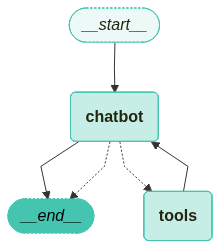

In [ ]:
########## 7. 그래프 시각화 ##########

# 그래프 시각화
visualize_graph(graph)

In [5]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_ihtFyiFGvLH99ksz2pHzQ3H2)
 Call ID: call_ihtFyiFGvLH99ksz2pHzQ3H2
  Args:
    query: AI


In [6]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next

('tools',)

In [7]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(existing_message.tool_calls)

    index [0]
        name: "search_keyword"
        args: {"query": "AI"}
        id: "call_ihtFyiFGvLH99ksz2pHzQ3H2"
        type: "tool_call"


In [8]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_ihtFyiFGvLH99ksz2pHzQ3H2)
 Call ID: call_ihtFyiFGvLH99ksz2pHzQ3H2
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxQbFZmdlNKeWdoNVFRVHNTZ2RhT3REb3QxWEVQTmVsM1hTdXdIcW1aTzJ3YjdVMnpoZG9DSkdudlpmRW5JV2ZqdU9sWHVubmY2YTlPdWxRdXd4OWw4TGE4Rk51cVYxYmdZV1g2SXNpdEFCbzB6TFk4RVBPVU5fclNtcWx3VdIBlwFBVV95cUxPcEpETXh2RFR0SDNkeFhxSjJYRkN6THg4ZWRrc0w3M1pWVUE2by13R3ZPZ3p3OEhKVzVYSDg4SFNJQ0pCcFcyRThMcnIxdWQ1RlR2SXNqd011ak1GTl9pMEpNUXlZZjlTd1pYN1JPU0E0Z2JxTy1ydXVWNnh4eWRXa1U2clFSMlN1emkyeEFNNVVkWGtFQXNZ?oc=5", "content": "AI 붐? 버블?...빅쇼트 주인공 버리 vs 젠슨 황의 논쟁 - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMidkFVX3lxTE5MN3FVNHd0U3U4bkd0ZmtPbHlwQTFsM3pUMmFqSnNqREM0Vk1Gc2RMNmRFdFBsQkNUR0VteHNWUDdTV0l0c0k1cF9xRDhyRWliaGdYS3B1RXdydFJwV2w4VFdmOXNQZnpLSUc

In [9]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state

메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  0 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------


In [10]:
# 다음 항목의 다음 요소 출력
print(to_replay.next)

# 다음 항목의 설정 정보 출력
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0cd1e9-72a4-6de2-8002-5c679e2cde72'}}


In [11]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cd1e9-72a4-6de2-8002-5c679e2cde72'}}

In [12]:
# `to_replay.config`는 `checkpoint_id`는 체크포인터에 저장된 상태에 해당
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxQbFZmdlNKeWdoNVFRVHNTZ2RhT3REb3QxWEVQTmVsM1hTdXdIcW1aTzJ3YjdVMnpoZG9DSkdudlpmRW5JV2ZqdU9sWHVubmY2YTlPdWxRdXd4OWw4TGE4Rk51cVYxYmdZV1g2SXNpdEFCbzB6TFk4RVBPVU5fclNtcWx3VdIBlwFBVV95cUxPcEpETXh2RFR0SDNkeFhxSjJYRkN6THg4ZWRrc0w3M1pWVUE2by13R3ZPZ3p3OEhKVzVYSDg4SFNJQ0pCcFcyRThMcnIxdWQ1RlR2SXNqd011ak1GTl9pMEpNUXlZZjlTd1pYN1JPU0E0Z2JxTy1ydXVWNnh4eWRXa1U2clFSMlN1emkyeEFNNVVkWGtFQXNZ?oc=5", "content": "AI 붐? 버블?...빅쇼트 주인공 버리 vs 젠슨 황의 논쟁 - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMidkFVX3lxTE5MN3FVNHd0U3U4bkd0ZmtPbHlwQTFsM3pUMmFqSnNqREM0Vk1Gc2RMNmRFdFBsQkNUR0VteHNWUDdTV0l0c0k1cF9xRDhyRWliaGdYS3B1RXdydFJwV2w4VFdmOXNQZnpLSUc0bFpHSXlTdFJMSFHSAWZBVV95cUxNc0x3RUstb05qMF8zSEh0YlpfX1NMN2tvd0NEWGtad3lEZzhoZVhzQXZ2NDJBd0pGREhadFZQbk5lQ3dGdGJPbVFvZE56bFFadGJ1Ql9LSDI5TlVMc09lMnBGTmRQNEE?oc=5", "content": "[단독]“韓, 생성형 AI 美中에 의존… ‘피지컬 